In [1]:
import torch
import numpy as np
import tools

In [2]:
def synthetic_data(seed=1984):
    np.random.seed(seed)
    N = 100  
    DIM = 2  
    CLS_NUM = 3  

    x = np.zeros((N*CLS_NUM, DIM))
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int32)

    for j in range(CLS_NUM):
        for i in range(N):
            rate = i / N
            radius = 1.0*rate
            theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

            ix = N*j + i
            x[ix] = np.array([radius*np.sin(theta),
                              radius*np.cos(theta)]).flatten()
            t[ix, j] = 1

    return x, t

In [3]:
class Linear:
    def __init__(self, dim_in, dim_out):
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.w = torch.rand(dim_in, dim_out, dtype=torch.float64)
        self.b = torch.rand(dim_out, dtype=torch.float64)
    def forward(self, x):
        self.x = x
        self.out = torch.matmul(x, self.w) + self.b
        return self.out
    def backward(self, dout):
        dx = torch.matmul(dout, self.w.T)
        self.dw = torch.matmul(self.x.T, dout)
        self.db = dout.sum(axis=0)
        return dx
    def update(self, lr):
        self.w -= lr * self.dw
        self.b -= lr * self.db

In [4]:
class Sigmoid:
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out
    def backward(self, dout):
        return dout * self.out * (1 - self.out)

In [5]:
class SoftmaxCrossEntropy:
    def forward(self, x, t):
        self.x = np.exp(x) / np.exp(x).sum(dim=-1, keepdim=True)
        shape = x.shape
        self.t_matrix = torch.zeros(shape)
        for i in range(shape[0]):
            t_l = t[i]
            self.t_matrix[i][t_l] = 1
        return (-np.log(self.x) * self.t_matrix).sum() / shape[0]
    def backward(self):
        return self.x - self.t_matrix

In [6]:
class net:
    def __init__(self, in_size, hidden_size, out_size):
        self.layers = [Linear(in_size, hidden_size), Sigmoid(), Linear(hidden_size, out_size)]
        self.cel = SoftmaxCrossEntropy()
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    def loss(self, x, t):
        score = self.predict(x)
        l = self.cel.forward(score, t)
        return l
    def backward(self):
        dout = self.cel.backward()
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
    def update(self, lr):
        for layer in self.layers:
            if type(layer) == Linear:
                layer.update(lr)

In [7]:
net = net(2, 10, 3)

In [8]:
indx = np.random.permutation(300)
x, y = synthetic_data()
x = x[indx]
y = y[indx]
x = torch.tensor(x, dtype=torch.float64)
y = torch.tensor(y, dtype=torch.float64)
y = y.argmax(dim=1)
x = x.reshape(10, 30, -1)
y = y.reshape(10, -1)

loss:0.077


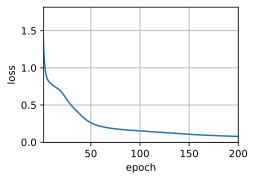

In [9]:
animator = tools.Animator(xlabel='epoch', ylabel='loss',xlim=[2,200])
for i in range(200):
    l_accum = 0.0
    for x_in, t_in in zip(x, y):
        l = net.loss(x_in, t_in)
        l_accum += l
        net.backward()
        net.update(0.1)
    animator.add(i + 1, (l_accum / 10, ))
print(f'loss:{float(l_accum / 10):.3f}')